Let's start with determining the scattering factors from abtem's multislice method using the FFT, and then see what we get when we calculate them with the eikonal method. 
Then we should see how to use the eikonal method to determine the phase shift and deflection angle of a plane wave incoming onto a potential.  

In [421]:
import matplotlib.pyplot as plt
import numpy as np
import abtem
from ase import Atoms
from abtem.core.energy import energy2wavelength
from scipy.interpolate import RegularGridInterpolator
%matplotlib ipympl

In [422]:
def get_phase_from_opl(opl, wavelength):
    return np.mod((opl/wavelength) * (2*np.pi), 2*np.pi)

def convert_slope_to_unit_vector(dx, dy):
    
    rho = np.sqrt(1 + dy ** 2 + dx ** 2)
    unit_vector_x = dx / rho
    unit_vector_y = dy / rho
    unit_vector_z = 1 / rho

    return np.array([unit_vector_x, unit_vector_y, unit_vector_z])

In [423]:
# Define the number of slices and slice thickness
slice_thickness = 0.1  # in Angstroms

# Calculate the total thickness of the cell
total_thickness = 4.0

num_slices = int(total_thickness / slice_thickness)

cell_x = 10.0
cell_y = 10.0
cell_z = total_thickness

# Create a cell with a large z-dimension
cell = [cell_x, cell_y, cell_z]  # 10x10 Angstroms in x and y, total_thickness in z

# Place a single gold atom at the center of the cell
position = [cell_x / 2, cell_y / 2, total_thickness / 2]
atoms = Atoms('Au', positions=[position], cell=cell, pbc=[False, False, False])

# Create the potential
potential = abtem.Potential(
    atoms,
    slice_thickness=slice_thickness,
    sampling=0.05,
    projection = 'finite'
)

PHI_0 = 80e3
wavelength = energy2wavelength(PHI_0)

# Compute the potential
V = potential.build().compute().array

# Define the offset (atom position)
offset = [0, 0, 0]  # Place the atom at the origin

half_x = cell[0] / 2
half_y = cell[1] / 2
half_z = cell[2] / 2

[                                        ] | 0% Completed | 1.84 ms

[########################################] | 100% Completed | 203.62 ms


In [424]:


k = 2 * np.pi / wavelength

V_xyz = PHI_0 - V.T

n = np.sqrt(V_xyz / PHI_0)
dndx, dndy, dndz = np.gradient(n)

nx, ny, nz = V.T.shape

x = np.linspace(-half_x, half_x, nx, endpoint = False)  # x coordinates
y = np.linspace(-half_y, half_y, ny, endpoint = False)  # y coordinates
z = np.linspace(-half_z, half_z, nz, endpoint = True)  # z coordinates

n_interp = RegularGridInterpolator((x, y, z), n, method = 'linear', bounds_error=False, fill_value=0.0)
dndx_interp = RegularGridInterpolator((x, y, z), dndx, method = 'linear', bounds_error=False, fill_value=0.0)
dndy_interp = RegularGridInterpolator((x, y, z), dndy, method = 'linear', bounds_error=False, fill_value=0.0)
dndz_interp = RegularGridInterpolator((x, y, z), dndz, method = 'linear', bounds_error=False, fill_value=0.0)

xx, yy = np.meshgrid(x, y)

In [425]:
def step_slice(r, z, dz, n, dndx, dndy, dndz):
    x, dx, y, dy, opl = r.T
    
    rho = np.sqrt(1 + dx **2 + dy ** 2)
    
    dx = dx + rho ** 2 / n((x, y, z)) * (dndx((x, y, z)) - dx * dndz((x, y, z))) * dz
    dy = dy + rho ** 2 / n((x, y, z)) * (dndy((x, y, z)) - dy * dndz((x, y, z))) * dz
    
    x = x + dx * dz
    y = y + dy * dz
    z = z + dz
    
    opl = opl + n((x, y, z)) * rho * dz
    
    r = np.vstack((x, dx, y, dy, opl)).T
    
    return r, z

def step_z(r, z, dz):
    x, dx, y, dy, opl = r.T
    rho = np.sqrt(1 + dx **2 + dy ** 2)
    
    
    x = x + dx * dz
    y = y + dy * dz
    z = z + dz
    opl += 1.0 * rho * dz
    
    r = np.vstack((x, dx, y, dy, opl)).T
    
    return r, z

In [426]:
num_rays = 1000
z0_atom = -half_z
dz = slice_thickness

x0s = np.linspace(-1, 1, num_rays)

# for x0 in x0s:
y0 = 0.0
z0 = -1000

dx0 = 0.0
dy0 = 0.0
opl0 = 0.0

rho = np.sqrt(dx0 ** 2 + dy0 ** 2)
dz0 = z0_atom - z0
z1 = z0 + dz0

r = np.zeros((num_rays, num_slices + 3, 5))

z_sol = np.zeros(num_slices + 3)
z_sol[0] = z0

r[:, 0, 0] = x0s
r[:, 0, 1:] = (dx0, y0, dy0, opl0)

# plt.axis('equal')

In [427]:

r[:, 1, :], z_sol[1] = step_z(r[:, 0, :], z_sol[0], dz0)
i_start = 1

for i in range(num_slices):
    r[:, i + i_start + 1, :], z_sol[i + i_start + 1] = step_slice(r[:, i + i_start, :], z_sol[i + i_start], dz, n_interp, dndx_interp, dndy_interp, dndz_interp)

dzend = 10000
r[:, -1, :], z_sol[-1] = step_z(r[:, -2, :], z_sol[-2], dzend)

x_sol = r[:, :, 0]

Text(0.5, 1.0, 'Particle Trajectory around atomic potential')

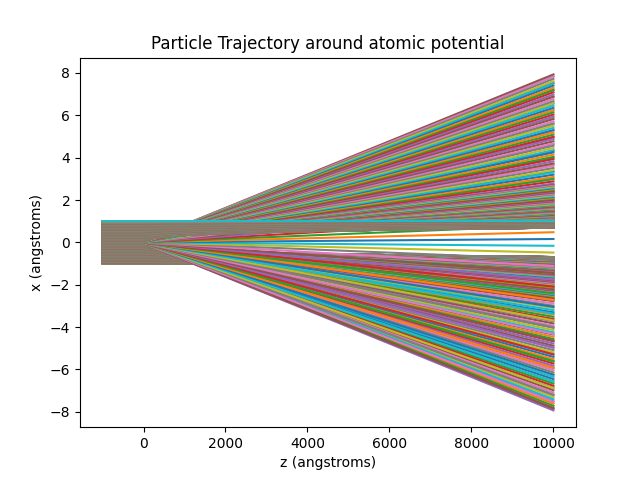

In [428]:
fig, ax = plt.subplots()
ax.plot(z_sol, x_sol.T, '-')
ax.set_xlabel("z (angstroms)")
ax.set_ylabel("x (angstroms)")
ax.set_title("Particle Trajectory around atomic potential")

In [429]:
n_pixels = 1000
detector_width_x = 10
detector_width_y = 0.0

detector_pixels_x = np.linspace(-detector_width_x/2, detector_width_x/2, n_pixels)
detector_pixels_y = np.linspace(-detector_width_y/2, detector_width_y/2, n_pixels)
detector_pixels_z = np.ones(n_pixels) * z_sol[-1]

det_points = np.vstack([detector_pixels_x, detector_pixels_y, detector_pixels_z]).T
det_pixels = np.zeros(n_pixels, np.complex128)

print(det_points.shape)
plt.plot(detector_pixels_z, detector_pixels_x, '.r')

(1000, 3)


In [430]:
x, dx, y, dy, opl = r[:, -1, :].T

ray_unit_direction_vector = convert_slope_to_unit_vector(dx, dy).T #z, x
ray_points = np.vstack([x, y, np.ones(num_rays) * z_sol[-1]]).T #z, x
ray_phase = get_phase_from_opl(opl, wavelength)

for i in range(num_rays):
    v = ray_points[i, :] - det_points
    dist = np.dot(v, ray_unit_direction_vector[i, :].T)
    phase_shift_to_detector = get_phase_from_opl(dist, wavelength)

    det_pixels += 1.0 * np.exp(1j * (ray_phase[i] + phase_shift_to_detector))
    
det_pixels = det_pixels

Text(0.5, 1.0, 'Phase')

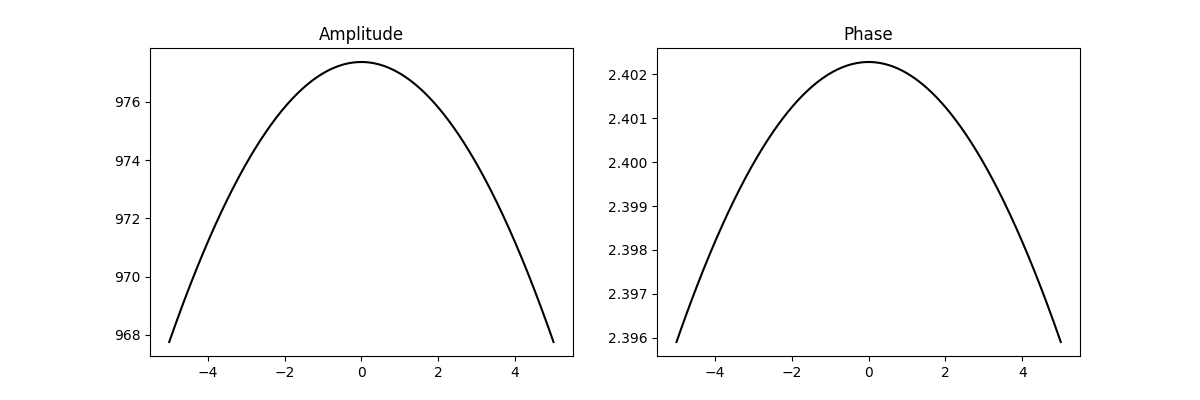

In [431]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12, 4))
ax[0].plot(detector_pixels_x, np.abs(det_pixels), color = 'k')
ax[0].set_title('Amplitude')
ax[1].plot(detector_pixels_x, np.angle(det_pixels), color = 'k')
ax[1].set_title('Phase')